## Predicting IPO Excess Returns: A Sentiment Analysis Approach

### Modelling 

In [18]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import random
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
df_IPO = pd.read_csv('df_IPO.csv', index_col=0)

In [3]:
print(df_IPO.head())

              Date Ticker  Offer date  Rollup  Dual  Internet  IPO Price  \
216659  2019-03-28   WTRE  2019-03-28     0.0   0.0       0.0      25.26   
216660  2019-03-28   SXTC  2019-01-04     0.0   0.0       0.0       4.00   
216661  2019-03-28   MDJH  2019-01-08     0.0   0.0       0.0       5.00   
216662  2019-03-28   BCOW  2019-01-09     0.0   0.0       0.0      10.00   
216663  2019-03-28    MTC  2019-01-08     0.0   0.0       0.0       4.00   

        Age at IPO  Excess_Return_1d  Excess_Return_1w  ...  compound_30_days  \
216659           5          0.000208          0.022772  ...          0.156603   
216660          13         -0.009199          0.096231  ...          0.156603   
216661           5         -0.020120         -0.056482  ...          0.156603   
216662          24          0.000375          0.036574  ...          0.156603   
216663          63         -0.014285         -0.017756  ...          0.156603   

        sentiment_45_days  subjectivity_45_days  neg_45_

In [4]:
df_IPO['Date'] = pd.to_datetime(df_IPO['Date'])
df_IPO.set_index('Date', inplace=True)


In [5]:
print(df_IPO.dtypes) 


Ticker                   object
Offer date               object
Rollup                  float64
Dual                    float64
Internet                float64
IPO Price               float64
Age at IPO                int64
Excess_Return_1d        float64
Excess_Return_1w        float64
Excess_Return_1m        float64
Excess_Return_3m        float64
Excess_Return_6m        float64
Excess_Return_1y        float64
sentiment_7_days        float64
subjectivity_7_days     float64
neg_7_days              float64
neu_7_days              float64
pos_7_days              float64
compound_7_days         float64
sentiment_14_days       float64
subjectivity_14_days    float64
neg_14_days             float64
neu_14_days             float64
pos_14_days             float64
compound_14_days        float64
sentiment_30_days       float64
subjectivity_30_days    float64
neg_30_days             float64
neu_30_days             float64
pos_30_days             float64
compound_30_days        float64
sentimen

In [6]:
print(df_IPO.isnull().sum()) 


Ticker                      0
Offer date                  0
Rollup                      0
Dual                        0
Internet                    0
IPO Price                   0
Age at IPO                  0
Excess_Return_1d          131
Excess_Return_1w          663
Excess_Return_1m         2751
Excess_Return_3m         7585
Excess_Return_6m        13163
Excess_Return_1y        17175
sentiment_7_days            0
subjectivity_7_days         0
neg_7_days                  0
neu_7_days                  0
pos_7_days                  0
compound_7_days             0
sentiment_14_days           0
subjectivity_14_days        0
neg_14_days                 0
neu_14_days                 0
pos_14_days                 0
compound_14_days            0
sentiment_30_days           0
subjectivity_30_days        0
neg_30_days                 0
neu_30_days                 0
pos_30_days                 0
compound_30_days            0
sentiment_45_days           0
subjectivity_45_days        0
neg_45_day

#### Correlation between Sentiment variables

We used both TextBlob sentiment and VADER compound score. Since the correlation between the variables is not a high as expacted, we will leave all variables in the model.  

In [7]:
# Define the groups of variables
groups = [
    ['sentiment_7_days', 'subjectivity_7_days', 'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days'],
    ['sentiment_14_days', 'subjectivity_14_days', 'neg_14_days', 'neu_14_days', 'pos_14_days', 'compound_14_days'],
    ['sentiment_30_days', 'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days', 'compound_30_days'],
    ['sentiment_45_days', 'subjectivity_45_days', 'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days'],
]

# Define the labels for each group
labels = ['7-day', '14-day', '30-day', '45-day']

# Compute the correlation matrix for each group of variables
for group, label in zip(groups, labels):
    df_subset = df_IPO[group]
    corr = df_subset.corr()
    print(f'Correlation Matrix for {label} Variables:')
    print(corr)
    print("\n" + "="*80 + "\n")  # print a line for clarity


Correlation Matrix for 7-day Variables:
                     sentiment_7_days  subjectivity_7_days  neg_7_days  \
sentiment_7_days             1.000000             0.694730   -0.217889   
subjectivity_7_days          0.694730             1.000000    0.357997   
neg_7_days                  -0.217889             0.357997    1.000000   
neu_7_days                  -0.476124            -0.839666   -0.625921   
pos_7_days                   0.663019             0.864212    0.342932   
compound_7_days              0.841149             0.724418   -0.228487   

                     neu_7_days  pos_7_days  compound_7_days  
sentiment_7_days      -0.476124    0.663019         0.841149  
subjectivity_7_days   -0.839666    0.864212         0.724418  
neg_7_days            -0.625921    0.342932        -0.228487  
neu_7_days             1.000000   -0.947243        -0.589645  
pos_7_days            -0.947243    1.000000         0.804115  
compound_7_days       -0.589645    0.804115         1.000000  


Next, let's take a look at the distribution of the target variables:

The histograms of the target variables show that the excess returns are mostly clustered around 0.

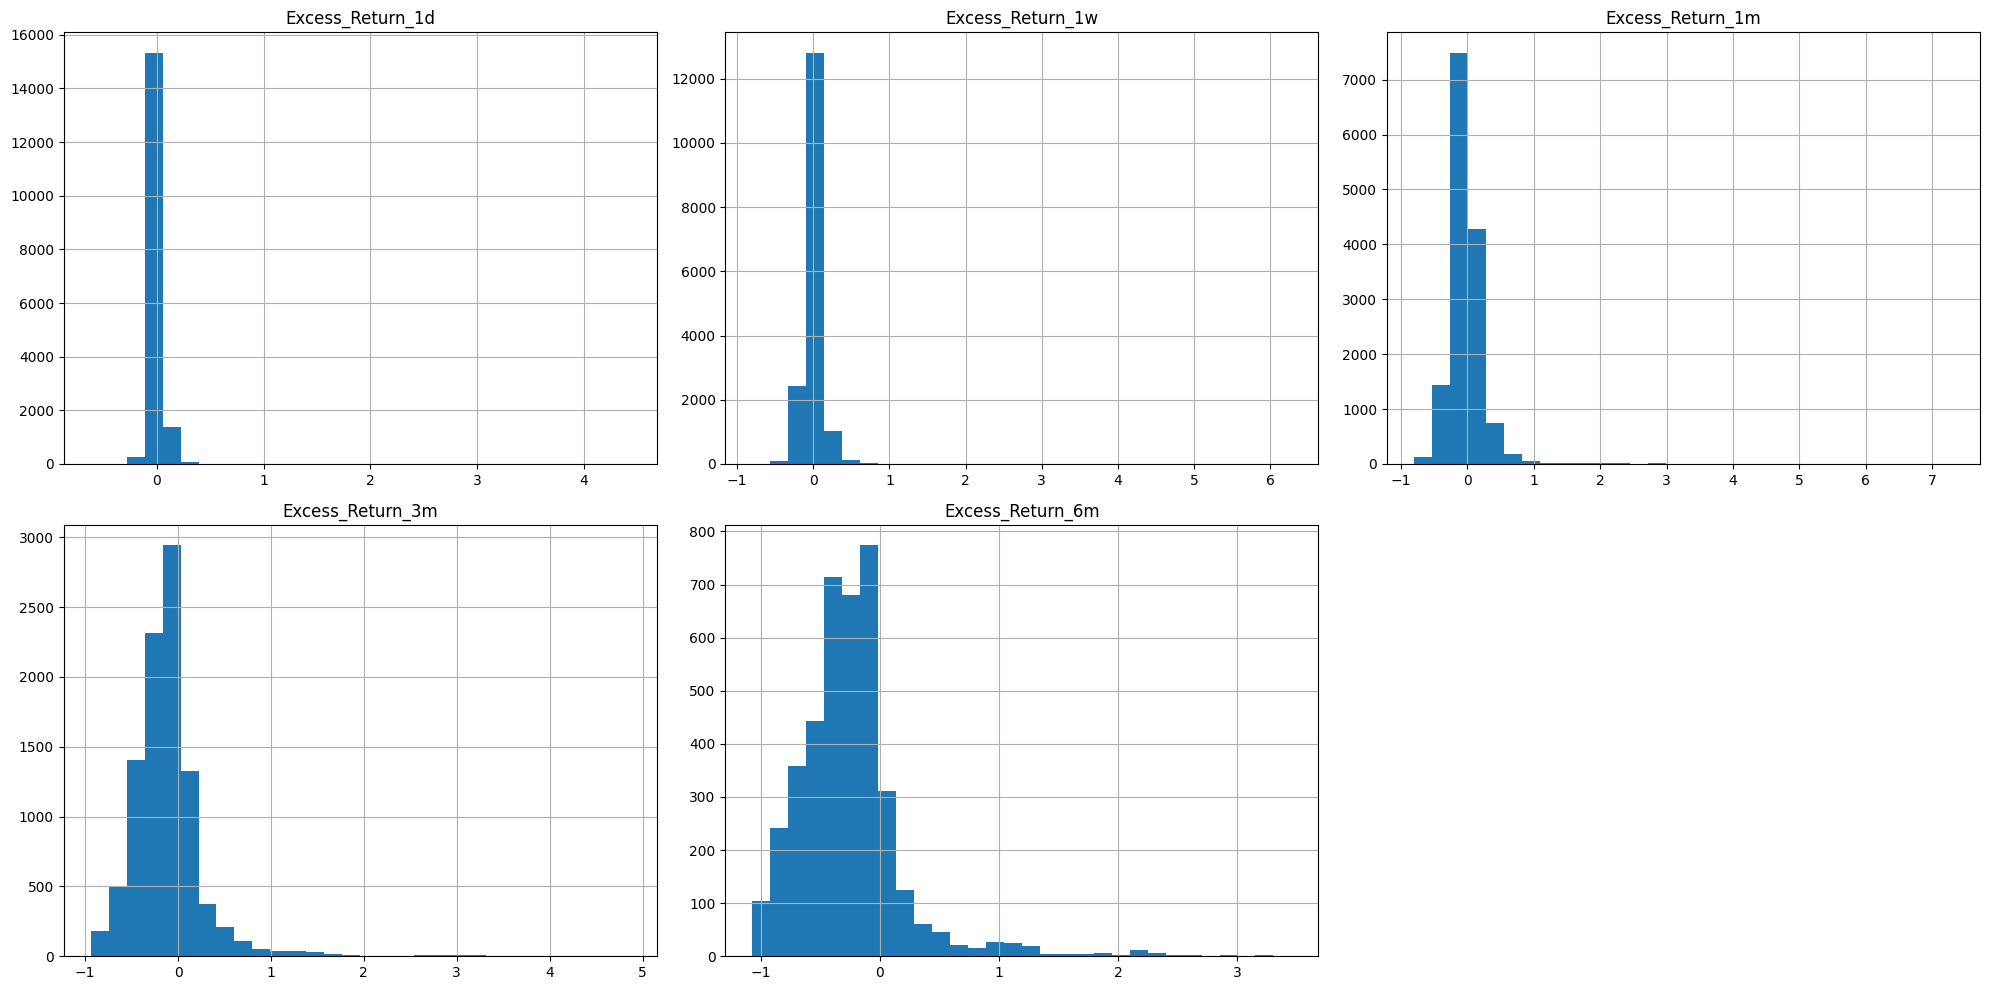

In [8]:
# Define the target variable
target = ['Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m']

# Plot histograms of the target variables
plt.figure(figsize=(20,10))

for i, column in enumerate(target, 1):
    plt.subplot(2, 3, i)
    df_IPO[column].dropna().hist(bins=30)  # We drop the NA values for the plotting
    plt.title(column)

plt.tight_layout()
plt.show()


### Pre-processing and Training Data

We will build  separate models for each excess return variable, using a slightly different dataset for each one. 
For each target variable, we should exclude the rows where that target variable is undefined before splitting the data into training and test sets.

The factors that influence one-day excess return may be different from those that influence one-week or one-month excess return. For instance, short-term returns could be more influenced by immediate market sentiment or specific events on the day of the IPO, while longer-term returns might be more influenced by the company's fundamentals, overall market conditions, or other factors.

Therefore, building separate models for each excess return target will allow you to capture these unique characteristics for each time period.

In [9]:
# Define predictors and target variables

predictors = [
    'Rollup', 'Dual', 'Internet',
    'IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days',
    'VC_0.0', 'VC_1.0', 'VC_2.0'
]


targets = ['Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m']

First we will run a linear regression model to have a base undestanding of the data

In [10]:
# Drop rows where 'Excess_Return_1d' is undefined
df_IPO_1d = df_IPO.dropna(subset=['Excess_Return_1d'])

# Split into training and testing datasets
X = df_IPO_1d[predictors]
y = df_IPO_1d['Excess_Return_1d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize the predictors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Compute the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse


0.06165784796695958

### Modelling Process

For each target variable, we create a separate dataframe where rows with undefined target variables are dropped. This is done to ensure that our models don't train on or try to predict undefined values.

Defining Predictors and Targets: We first specify the features (predictors) that we'll use to predict the target variables (excess returns over different periods).

1. Preparing the Data: For each target variable, we create a separate dataframe where rows with undefined target variables are dropped. This is done to ensure that our models don't train on or try to predict undefined values.

2. Splitting the Data: We split our data into training and testing sets. This is a common practice in machine learning, where we use the training set to train our model, and then we test the model's predictions on the test set.

3. Standardizing the Data: We standardize our predictor variables so they're on the same scale. This is especially important for linear models and models that use regularization, like Ridge and Lasso, because features on larger scales can unduly influence the model.

4. Training Models: We train several types of models: Linear Regression, Ridge Regression, Lasso Regression, and Random Forest Regression.

For the Ridge and Lasso models, we use GridSearch to find the best value for the regularization parameter. 
For the Random Forest model, we also use GridSearch to find the best values for the number of trees in the forest (n_estimators) and the maximum depth of the trees (max_depth).

Model Selection: We compare the models based on their Root Mean Squared Error (RMSE) on the validation set, which is a measure of how accurately the model predicts the target variable. The model with the lowest RMSE is selected as the best model for each target variable.

In [11]:
# Initialize a dictionary to store the best models for each target
best_models = {}

# For each target variable, prepare the data, train the models, and find the best model
for target in targets:
    # Drop rows where the target variable is undefined
    df = df_IPO.dropna(subset=[target])
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)
    
    # Standardize the predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train a linear regression model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    lr_rmse = mean_squared_error(y_test, lr.predict(X_test_scaled), squared=False)
    
    # Train a ridge regression model
    ridge = Ridge(random_state=42)
    params_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_root_mean_squared_error')
    grid_ridge.fit(X_train_scaled, y_train)
    ridge_rmse = -grid_ridge.best_score_
    
    # Train a lasso regression model
    lasso = Lasso(random_state=42)
    params_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_lasso = GridSearchCV(lasso, params_lasso, cv=5, scoring='neg_root_mean_squared_error')
    grid_lasso.fit(X_train_scaled, y_train)
    lasso_rmse = -grid_lasso.best_score_
    
    # Train a random forest model
    rf = RandomForestRegressor(random_state=42)
    params_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
    grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='neg_root_mean_squared_error')
    grid_rf.fit(X_train_scaled, y_train)
    rf_rmse = -grid_rf.best_score_
    
    # Find the best model for this target
    models = {'Linear Regression': [lr, lr_rmse], 'Ridge Regression': [grid_ridge.best_estimator_, ridge_rmse], 
              'Lasso Regression': [grid_lasso.best_estimator_, lasso_rmse], 'Random Forest': [grid_rf.best_estimator_, rf_rmse]}
    best_model = min(models.items(), key=lambda x: x[1][1])
    best_models[target] = best_model

best_models


{'Excess_Return_1d': ('Lasso Regression',
  [Lasso(alpha=0.001, random_state=42), 0.06299504612296922]),
 'Excess_Return_1w': ('Random Forest',
  [RandomForestRegressor(random_state=42), 0.1370074323032884]),
 'Excess_Return_1m': ('Random Forest',
  [RandomForestRegressor(random_state=42), 0.1720244586568542]),
 'Excess_Return_3m': ('Random Forest',
  [RandomForestRegressor(random_state=42), 0.2020877448980331]),
 'Excess_Return_6m': ('Random Forest',
  [RandomForestRegressor(max_depth=10, random_state=42), 0.29081893517617863])}

The results indicate that the best performing model varied depending on the excess return target variable:

Excess_Return_1d: The Lasso Regression model performed the best with an alpha of 0.001. The Root Mean Squared Error (RMSE) on the validation set was approximately 0.063.

Excess_Return_1w: The Random Forest model was the best performer. The RMSE on the validation set was approximately 0.137.

Excess_Return_1m: The Random Forest model was again the best performer. The RMSE on the validation set was approximately 0.172.

Excess_Return_3m: The Random Forest model was the best performer. The RMSE on the validation set was approximately 0.202.

Excess_Return_6m: The Random Forest model with a maximum depth of 10 was the best performer. The RMSE on the validation set was approximately 0.291.

Lets plot the RMSE scores to compare the performance of the best models for each target variable

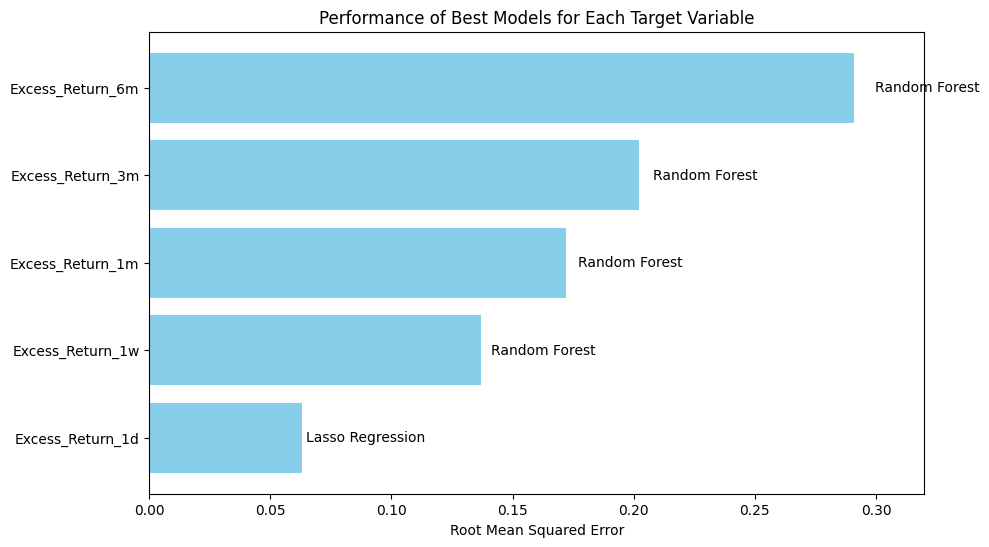

In [12]:
# Extract the RMSE scores and model names for each target
rmse_scores = [model[1][1] for model in best_models.values()]
model_names = [model[0] for model in best_models.values()]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(targets, rmse_scores, color='skyblue')
plt.xlabel('Root Mean Squared Error')
plt.title('Performance of Best Models for Each Target Variable')
plt.xlim([0, max(rmse_scores)*1.1])  # to leave some space on the right side

# Add the model names on the right
for i, model_name in enumerate(model_names):
    plt.text(x=rmse_scores[i]*1.03, y=i, s=model_name, va='center')

plt.show()


### Hyperparameter Tunning 

In the Lasso model for 'Excess_Return_1d' we saw that the best alpha was at one end of your grid (i.e., 0.001). We will create a more refined grid around this value to see if there's a better choice.

Similarly, for the Random Forest model, we will look into tuning other parameters such as max_features, min_samples_split, and min_samples_leaf, in addition to n_estimators and max_depth.

In [13]:
# Further tune Lasso for 'Excess_Return_1d'
params_lasso_refined = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]}
grid_lasso_refined = GridSearchCV(Lasso(random_state=42), params_lasso_refined, cv=5, scoring='neg_root_mean_squared_error')
grid_lasso_refined.fit(X_train_scaled, y_train)
lasso_refined_rmse = -grid_lasso_refined.best_score_

print(f"Best alpha for Lasso: {grid_lasso_refined.best_params_['alpha']}")
print(f"Best RMSE for Lasso: {lasso_refined_rmse}")

C:\Users\restr\anaconda3\envs\pyt310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e+00, tolerance: 5.710e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\restr\anaconda3\envs\pyt310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e-01, tolerance: 5.461e-02
  model = cd_fast.enet_coordinate_descent(


Best alpha for Lasso: 0.005
Best RMSE for Lasso: 0.4446699629552412


In [14]:
# Further tune Lasso for 'Excess_Return_1d' with increased iterations
lasso_refined = Lasso(alpha=0.005, max_iter=10000, random_state=42)
lasso_refined.fit(X_train_scaled, y_train)
lasso_refined_rmse = mean_squared_error(y_test, lasso_refined.predict(X_test_scaled), squared=False)

print(f"RMSE for refined Lasso: {lasso_refined_rmse}")


RMSE for refined Lasso: 0.45321979241133764


Now we will tune the parameters of the random forest models.

Because of limited computational resources to tune the Hyperparameters, instead of using GridSearchCV, which exhaustively searches through all the possible combinations of hyperparameters, we will use RandomizedSearchCV.

RandomizedSearchCV samples a fixed number of hyperparameter combinations from the specified hyperparameter space. This can be significantly faster while still giving a good approximation of the best hyperparameters

In [20]:
# Define targets
targets = ['Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m']

# Initialize a dictionary to store the best models for each target
best_rf_models = {}

# Hyperparameters to be tested
params_rf_randomized = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15],
    'max_features': [1.0, 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# For each target variable, prepare the data, train the model, and find the best model
for target in targets:
    # Drop rows where the target variable is undefined
    df = df_IPO.dropna(subset=[target])
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)
    
    # Standardize the predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform Randomized Search
    random_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), params_rf_randomized, cv=5, scoring='neg_root_mean_squared_error', n_iter=100, random_state=42)
    random_rf.fit(X_train_scaled, y_train)
    rf_random_rmse = -random_rf.best_score_
    
    # Store the best model for this target
    best_rf_models[target] = (random_rf.best_estimator_, rf_random_rmse)

# Print out the best models for each target
for target, model in best_rf_models.items():
    print(f"Best Random Forest model for {target}: {model[0]}")
    print(f"Best RMSE for {target}: {model[1]}")




Best Random Forest model for Excess_Return_1d: RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=10,
                      n_estimators=50, random_state=42)
Best RMSE for Excess_Return_1d: 0.06295119666100828
Best Random Forest model for Excess_Return_1w: RandomForestRegressor(min_samples_split=5, n_estimators=400, random_state=42)
Best RMSE for Excess_Return_1w: 0.136674835689013
Best Random Forest model for Excess_Return_1m: RandomForestRegressor(n_estimators=300, random_state=42)
Best RMSE for Excess_Return_1m: 0.17010422065013314
Best Random Forest model for Excess_Return_3m: RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)
Best RMSE for Excess_Return_3m: 0.1976396900267728
Best Random Forest model for Excess_Return_6m: RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)
Best RMSE for Excess_Return_6m: 0.27379958604067767


### Fitting the models using the optimal hyperparameters we found

We will train each model on the training dataset and then evaluate it on the test dataset:

For 1d excess return, using Lasso Regression:

In [21]:
# Drop rows where the target variable is undefined
df_IPO_1d = df_IPO.dropna(subset=['Excess_Return_1d'])

# Split data for the target 'Excess_Return_1d'
X_train_1d, X_test_1d, y_train_1d, y_test_1d = train_test_split(df_IPO_1d[predictors], df_IPO_1d['Excess_Return_1d'], test_size=0.2, random_state=42)

# Standardize the predictors
scaler_1d = StandardScaler()
X_train_scaled_1d = scaler_1d.fit_transform(X_train_1d)
X_test_scaled_1d = scaler_1d.transform(X_test_1d)

# Train the Lasso model with the optimal alpha
lasso_optimal_1d = Lasso(alpha=0.005, random_state=42)
lasso_optimal_1d.fit(X_train_scaled_1d, y_train_1d)

# Evaluate the model
lasso_rmse_1d = mean_squared_error(y_test_1d, lasso_optimal_1d.predict(X_test_scaled_1d), squared=False)
print(f"RMSE for optimal Lasso on Excess_Return_1d: {lasso_rmse_1d}")



RMSE for optimal Lasso on Excess_Return_1d: 0.07186880454171204


In [22]:
# Assuming `lasso_optimal_1d` is your Lasso model
coef = lasso_optimal_1d.coef_
for feature, coef_val in zip(predictors, coef):
    print(f'{feature}: {coef_val}')


Rollup: 0.0
Dual: -0.0
Internet: -0.0
IPO Price: 0.0
Age at IPO: -0.0
sentiment_7_days: 0.0
subjectivity_7_days: 0.0
neg_7_days: -0.0
neu_7_days: -0.0
pos_7_days: 0.0
compound_7_days: 0.0
sentiment_14_days: 0.0
subjectivity_14_days: 0.0
neg_14_days: -0.0
neu_14_days: 0.0
pos_14_days: 0.0
compound_14_days: 0.0
sentiment_30_days: 0.0
subjectivity_30_days: 0.0
neg_30_days: -0.0
neu_30_days: 0.0
pos_30_days: 0.0
compound_30_days: 0.0
sentiment_45_days: 0.0
subjectivity_45_days: 0.0
neg_45_days: -0.0
neu_45_days: 0.0
pos_45_days: 0.0
compound_45_days: 0.0
VC_0.0: -0.0
VC_1.0: 0.0
VC_2.0: -0.0


The fact that all of the coefficients are zero (or nearly zero) means that the Lasso regression has found that none of the features are useful in predicting the target variable, Excess_Return_1d, for the given data. The regularization term has essentially pushed all the coefficients towards zero, rendering the model almost equivalent to a constant prediction.

The model has practicly no predicting power, not much different than the simple linear regression we performed previously (RMSE = 0.0616). 

Now for the other targets (1d, 1w, 1m, 3m, 6m), using Random Forest:


Feature importances for Excess_Return_1d:
                 Feature  Importance
4             Age at IPO    0.197921
3              IPO Price    0.162060
19           neg_30_days    0.090602
25           neg_45_days    0.069086
23     sentiment_45_days    0.059798
13           neg_14_days    0.032976
5       sentiment_7_days    0.031311
22      compound_30_days    0.031005
2               Internet    0.029371
14           neu_14_days    0.026898
7             neg_7_days    0.026418
10       compound_7_days    0.017984
12  subjectivity_14_days    0.017381
28      compound_45_days    0.017354
17     sentiment_30_days    0.017307
11     sentiment_14_days    0.017175
20           neu_30_days    0.017015
24  subjectivity_45_days    0.014840
9             pos_7_days    0.014793
0                 Rollup    0.014533
30                VC_1.0    0.011850
26           neu_45_days    0.010745
8             neu_7_days    0.010604
16      compound_14_days    0.010488
27           pos_45_days    0.01

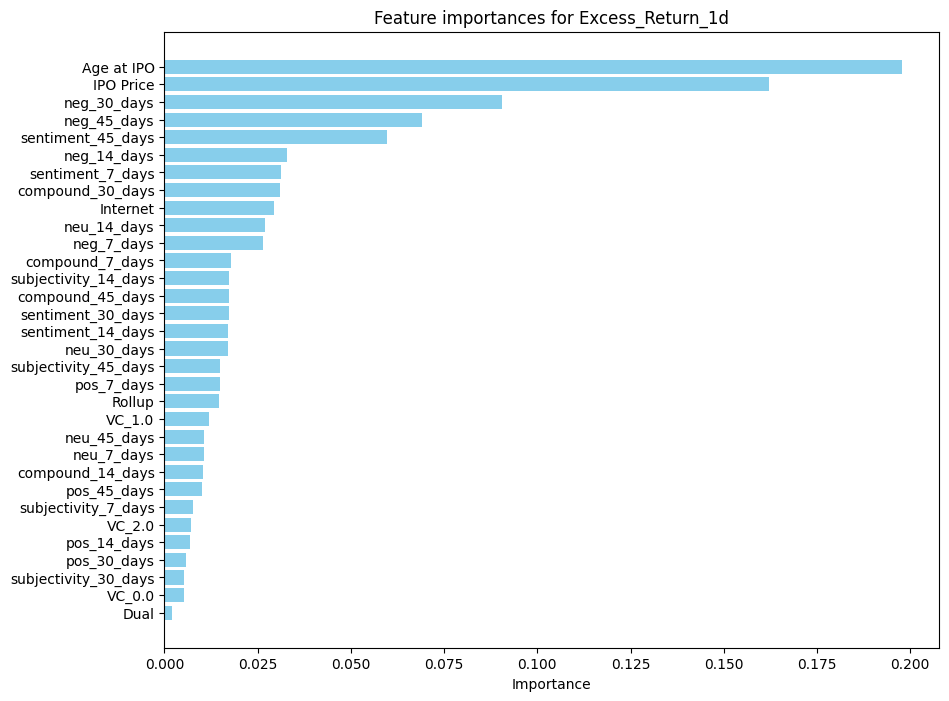

RMSE for optimal Random Forest on Excess_Return_1d: 0.07163314423360156

Feature importances for Excess_Return_1w:
                 Feature  Importance
4             Age at IPO    0.322281
3              IPO Price    0.202134
2               Internet    0.033585
26           neu_45_days    0.025643
1                   Dual    0.022840
25           neg_45_days    0.020990
13           neg_14_days    0.020370
23     sentiment_45_days    0.019973
11     sentiment_14_days    0.019766
17     sentiment_30_days    0.018676
14           neu_14_days    0.018176
20           neu_30_days    0.017606
19           neg_30_days    0.016700
5       sentiment_7_days    0.016376
8             neu_7_days    0.016071
9             pos_7_days    0.015661
6    subjectivity_7_days    0.015179
27           pos_45_days    0.015094
18  subjectivity_30_days    0.013994
10       compound_7_days    0.013579
24  subjectivity_45_days    0.013211
7             neg_7_days    0.013173
28      compound_45_days    0.0127

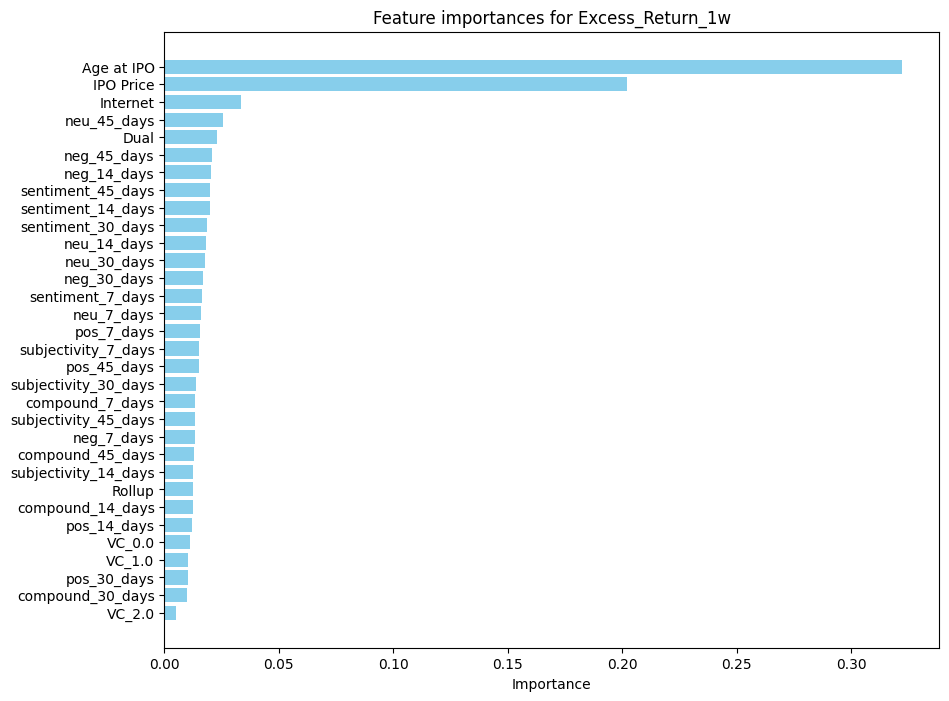

RMSE for optimal Random Forest on Excess_Return_1w: 0.12297390077665916

Feature importances for Excess_Return_1m:
                 Feature  Importance
4             Age at IPO    0.299817
3              IPO Price    0.201423
25           neg_45_days    0.039305
18  subjectivity_30_days    0.028353
1                   Dual    0.025716
2               Internet    0.024563
28      compound_45_days    0.022580
23     sentiment_45_days    0.022253
14           neu_14_days    0.022089
15           pos_14_days    0.021148
6    subjectivity_7_days    0.018761
12  subjectivity_14_days    0.018696
17     sentiment_30_days    0.018641
11     sentiment_14_days    0.017837
0                 Rollup    0.015806
26           neu_45_days    0.015684
24  subjectivity_45_days    0.015091
19           neg_30_days    0.014579
20           neu_30_days    0.014476
27           pos_45_days    0.013791
8             neu_7_days    0.012998
16      compound_14_days    0.012980
9             pos_7_days    0.0128

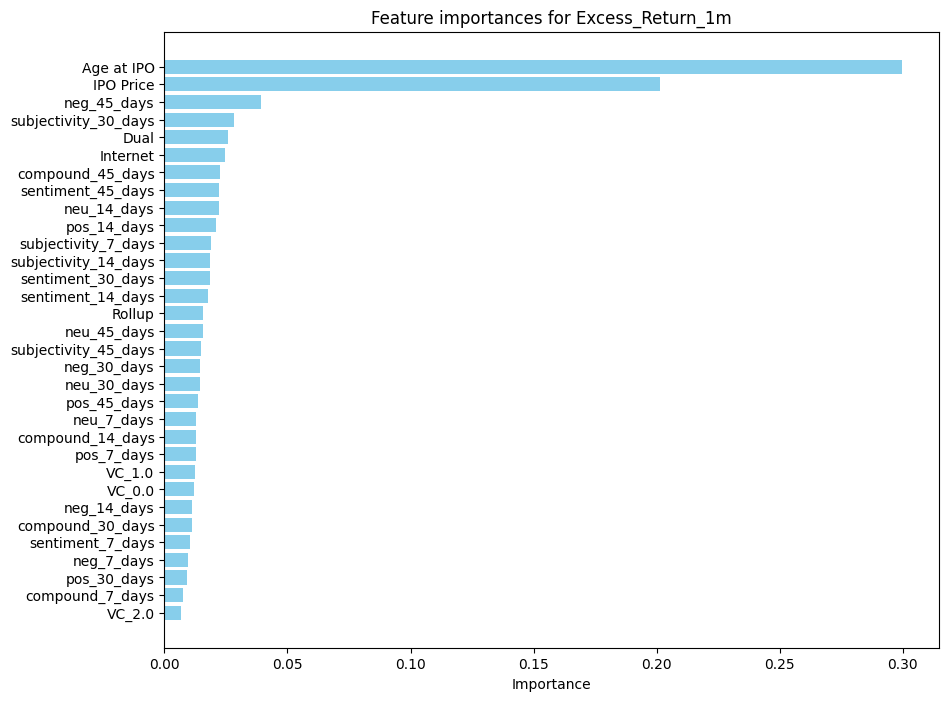

RMSE for optimal Random Forest on Excess_Return_1m: 0.14602309770803235

Feature importances for Excess_Return_3m:
                 Feature  Importance
4             Age at IPO    0.324731
3              IPO Price    0.250430
1                   Dual    0.042598
27           pos_45_days    0.027109
12  subjectivity_14_days    0.025207
30                VC_1.0    0.023233
25           neg_45_days    0.022489
28      compound_45_days    0.020965
18  subjectivity_30_days    0.020437
29                VC_0.0    0.018845
23     sentiment_45_days    0.018684
22      compound_30_days    0.018407
17     sentiment_30_days    0.017866
2               Internet    0.015779
26           neu_45_days    0.013931
24  subjectivity_45_days    0.012138
11     sentiment_14_days    0.011830
6    subjectivity_7_days    0.011117
16      compound_14_days    0.011035
19           neg_30_days    0.010950
5       sentiment_7_days    0.010727
15           pos_14_days    0.009925
10       compound_7_days    0.0085

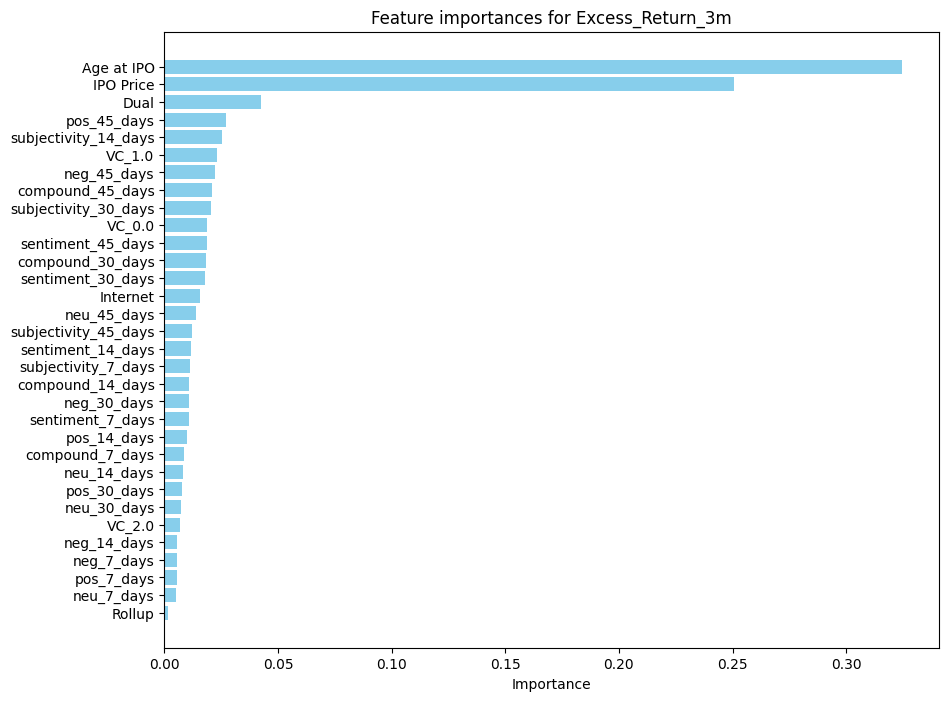

RMSE for optimal Random Forest on Excess_Return_3m: 0.17505334127642352

Feature importances for Excess_Return_6m:
                 Feature  Importance
3              IPO Price    0.323075
4             Age at IPO    0.291084
29                VC_0.0    0.040593
30                VC_1.0    0.036403
1                   Dual    0.030829
27           pos_45_days    0.021460
31                VC_2.0    0.020938
17     sentiment_30_days    0.019635
5       sentiment_7_days    0.016606
25           neg_45_days    0.015601
18  subjectivity_30_days    0.014932
11     sentiment_14_days    0.013786
28      compound_45_days    0.013584
23     sentiment_45_days    0.012062
24  subjectivity_45_days    0.010526
12  subjectivity_14_days    0.010313
19           neg_30_days    0.010203
26           neu_45_days    0.009280
6    subjectivity_7_days    0.008609
7             neg_7_days    0.008393
14           neu_14_days    0.007602
15           pos_14_days    0.007596
0                 Rollup    0.0073

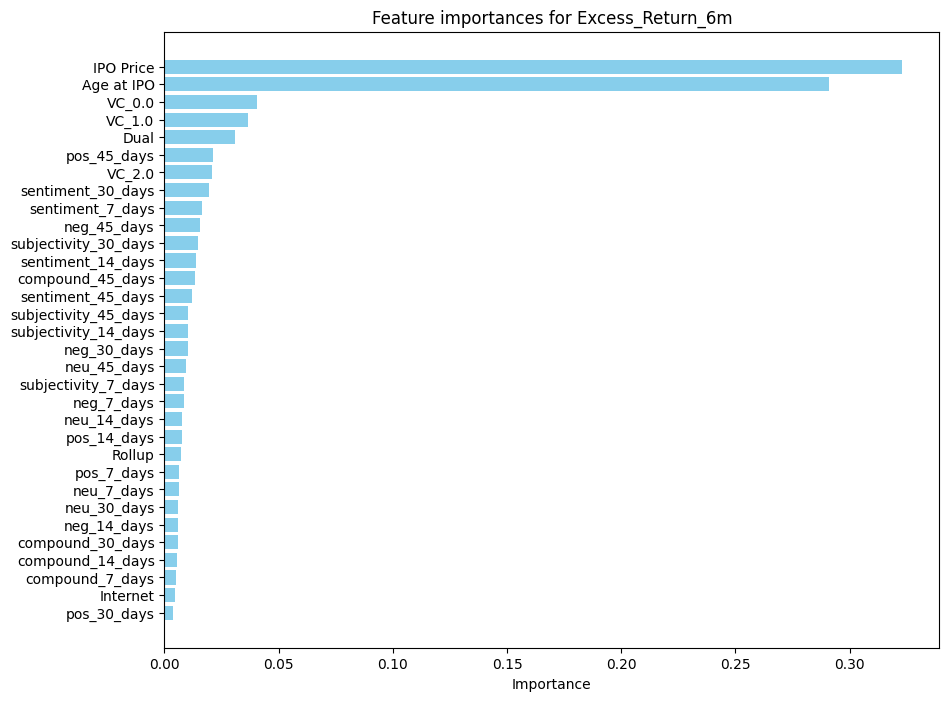

RMSE for optimal Random Forest on Excess_Return_6m: 0.29661885092636625


In [25]:
# Define the targets and their corresponding optimal parameters
targets_rf = ['Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m']
optimal_params_rf = [
    {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50},
    {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400},
    {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300},
    {'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
]

# Train and evaluate Random Forest for each target
for target, params in zip(targets_rf, optimal_params_rf):
    # Drop rows where the target variable is undefined
    df = df_IPO.dropna(subset=[target])
    
    # Split the data into training and test sets
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)
    
    # Standardize the predictors
    scaler_rf = StandardScaler()
    X_train_scaled_rf = scaler_rf.fit_transform(X_train_rf)
    X_test_scaled_rf = scaler_rf.transform(X_test_rf)
    
    # Train the Random Forest model with the optimal parameters
    rf_optimal = RandomForestRegressor(**params, random_state=42)
    rf_optimal.fit(X_train_scaled_rf, y_train_rf)
    
    # Get feature importances
    importances = rf_optimal.feature_importances_
    
    # Create a DataFrame
    feature_importances_df = pd.DataFrame({
        'Feature': predictors,
        'Importance': importances
    })
    
    # Sort the DataFrame by importance
    feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Print the feature importances
    print(f"\nFeature importances for {target}:")
    print(feature_importances_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature importances for {target}')
    plt.gca().invert_yaxis()
    plt.show()
    
    # Evaluate the model
    rf_rmse = mean_squared_error(y_test_rf, rf_optimal.predict(X_test_scaled_rf), squared=False)
    print(f"RMSE for optimal Random Forest on {target}: {rf_rmse}")


# Results

Our analysis revealed that the Random Forest model performed well with varying degrees of accuracy in predicting excess returns for different time horizons. We observed an increasing RMSE pattern as the time horizon for the excess returns extended. This suggests that predictive accuracy diminishes for longer time horizons due to the inherent volatility of the market and numerous other influencing factors, which complicate long-term predictions.

The following are the RMSE values for the optimal models:

Excess Return 1 Day: 0.0716

Excess Return 1 Week: 0.1230

Excess Return 1 Month: 0.1460

Excess Return 3 Months: 0.1750

Excess Return 6 Months: 0.2966

Impact of Sentiment Scores: The sentiment variables derived from TextBlob and VADER provided inconsistent results across different time intervals. They sometimes emerged among the top influential features, while at other times, their impact was relatively lower. For example, sentiment scores from the past 45 days ('sentiment_45_days') were significantly influential in predicting 1-day and 1-week excess returns, but less so for longer periods.

Most Important Features: Most notably, the two dominant features across all models were 'Age at IPO' and 'IPO Price.' This underscores the role the company's characteristics play in influencing IPO performance.



# Conclusions

In this case study, we aimed at predicting IPO excess returns for the years 2019 to 2021 across different time intervals using a range of predictor variables.
We were particularly interested in exploring whether a broad sentiment score, derived from Twitter sentiment analysis concerning tech giants Amazon, Apple, Google, Microsoft, and Tesla, can help predict IPO excess returns.

Steps followed:

1. Data Cleaning and Preprocessing: We ensured that the data was appropriately cleaned, and missing values were handled.

2. Feature Selection: Selected features were used as predictors, including sentiment analysis data.

3. Model Selection: We utilized Lasso Regression and Random Forest Regressors to predict excess returns.

4. Hyperparameter Tuning: We employed RandomizedSearchCV to find the optimal hyperparameters for each target variable.

5. Model Training and Validation: The optimal models were then trained on the training data and validated on the test data.


While we successfully implemented predictive modeling, the results may not be considered robust. Overall, it is evident that a mix of traditional financial indicators and contemporary data like sentiment analysis from social media platforms can indeed predict IPO excess returns to a certain degree. However, the accuracy decreases over longer-term horizons, indicating the complexity and dynamism of financial markets.


## Future Directions:

Expanding Data Sample: Looking at a larger dataset of IPOs, considering more features, or integrating a larger collection of Twitter data could lead to more insightful findings.

Advanced Sentiment Analysis: Applying more advanced sentiment analysis techniques that consider the context and content of tweets might improve prediction accuracy.


While the models developed in this case study can offer some degree of insight and predictive power, it is important to understand their limitations and use them in conjunction with other tools and information. Future work could consider additional predictors, such as more detailed financial information, broader macroeconomic indicators, and more sophisticated sentiment analysis techniques that take into account the context and source of the sentiment.